# PERFORMANCE OF HEDGED CREDIT

AUTHOR: [@sparshsah](https://github.com/sparshsah)

In [1]:
# ignore: just data loading + cleaning

import sys
# https://github.com/sparshsah/foggy-lib/tree/main/util
sys.path.insert(0, "../../../foggy-lib/util")
del sys

import pandas as pd
# https://github.com/sparshsah/foggy-lib/tree/main/util/foggy_pylib
import foggy_pylib.fin as fin


def _read_csv(fname):
    return pd.read_csv(fname, index_col=0, parse_dates=True).sort_index().squeeze()

def _get_bond_r_from_yld(fname: str, name: str, dur: float=fin.DEFAULT_BOND_DUR, xr: bool=False) -> fin.FloatSeries:
    yld = _read_csv(fname=fname)
    yld = yld.apply(lambda y: None if y == "." else y)
    yld = yld.ffill(limit=3)
    yld = yld.astype(float)
    yld = yld / 100  # comes as pctg
    yld = yld.rename(name)
    r = fin.get_r_from_yld(yld=yld, dur=dur)
    if xr:
        r = fin.get_xr(r=r, cash_r=TBILL_R)
    return r

def get_tbill_r():
    return _get_bond_r_from_yld(fname="data/fred-3m-tbill-secondary-yld.csv", name="tbill3m", dur=0.25)

def get_ty_xr():
    return _get_bond_r_from_yld(fname="data/fred-2y-treasury-mkt-yld.csv", name="tnote2Y", dur=1.9, xr=True)

def get_mbs_xr():
    px = _read_csv("data/invesco-us-mbs-index-px.csv")
    r = fin.get_r_from_px(px=px)
    xr = fin.get_xr(r=r, cash_r=TBILL_R)
    xr = xr.rename("mbs")
    return xr

def get_spx_xr():
    px = _read_csv("data/yahoo-finance-spy-px.csv")
    px = px["Adj Close"]
    r = fin.get_r_from_px(px=px)
    xr = fin.get_xr(r=r, cash_r=TBILL_R)
    xr = xr.rename("spx")
    return xr

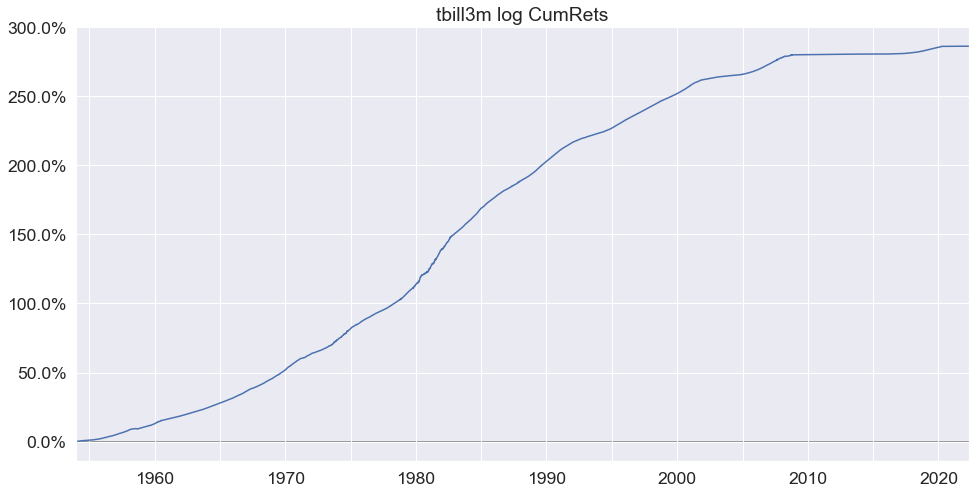

Sharpe    6.217374
ER        0.041920
Vol       0.006742
dtype: float64


In [2]:
TBILL_R = get_tbill_r()
fin.chart(TBILL_R)

# performance of vol-targeted passive assets

## government bonds

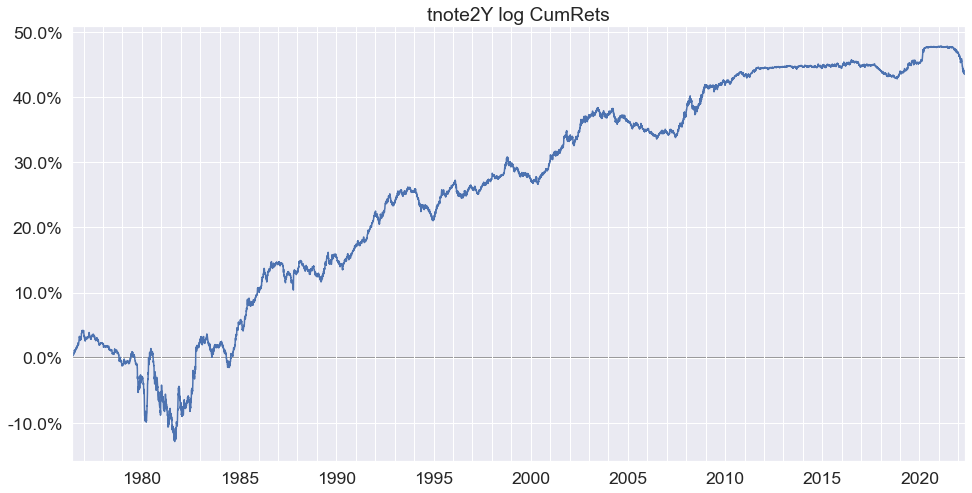

Sharpe    0.401271
ER        0.009478
Vol       0.023620
dtype: float64


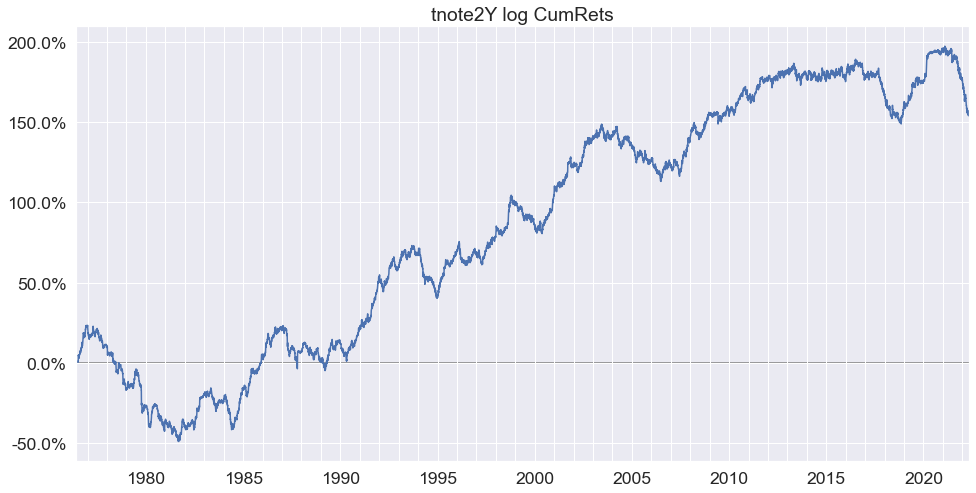

Sharpe    0.319077
ER        0.033607
Vol       0.105325
dtype: float64


In [3]:
_TY_XR = get_ty_xr()
TY_XR = fin.get_vol_targeted(xr=_TY_XR)

fin.chart(r=_TY_XR)
fin.chart(r=TY_XR)

## mortgage-backed securities

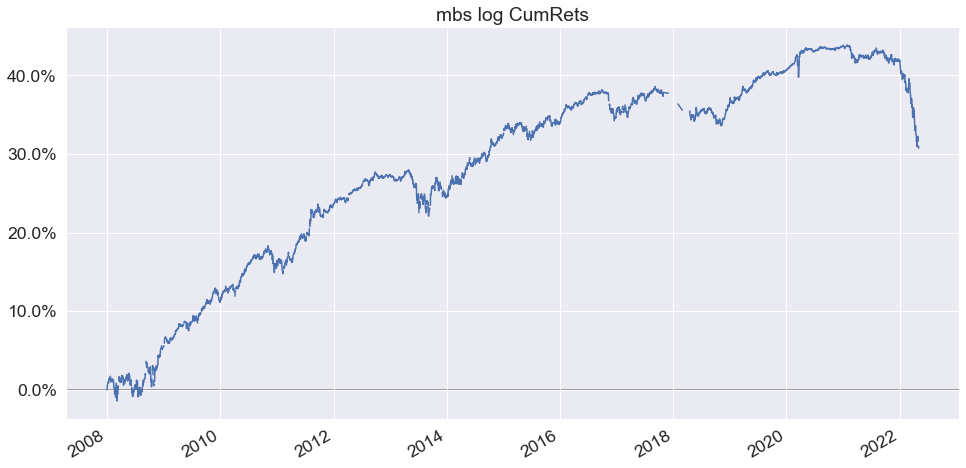

Sharpe    0.492578
ER        0.022412
Vol       0.045500
dtype: float64


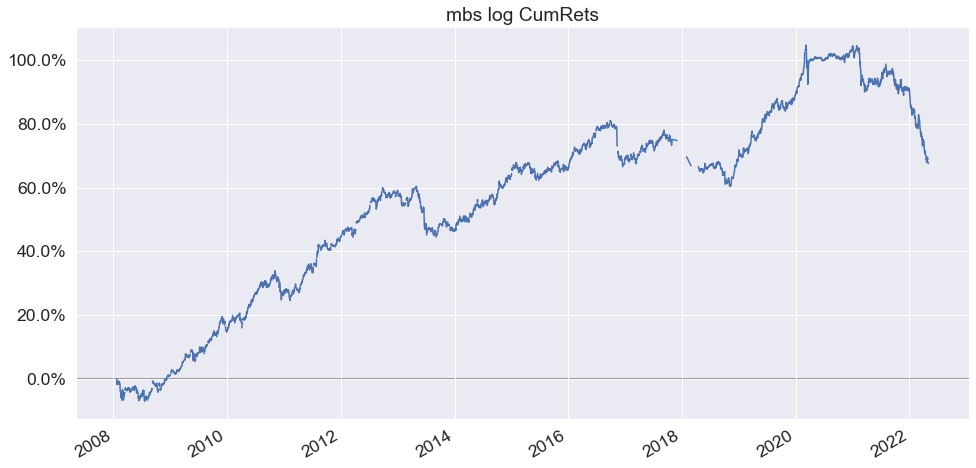

Sharpe    0.451352
ER        0.049323
Vol       0.109278
dtype: float64


In [4]:
_MBS_XR = get_mbs_xr()
MBS_XR = fin.get_vol_targeted(xr=_MBS_XR)

fin.chart(r=_MBS_XR)
fin.chart(r=MBS_XR)

## developed-market stocks

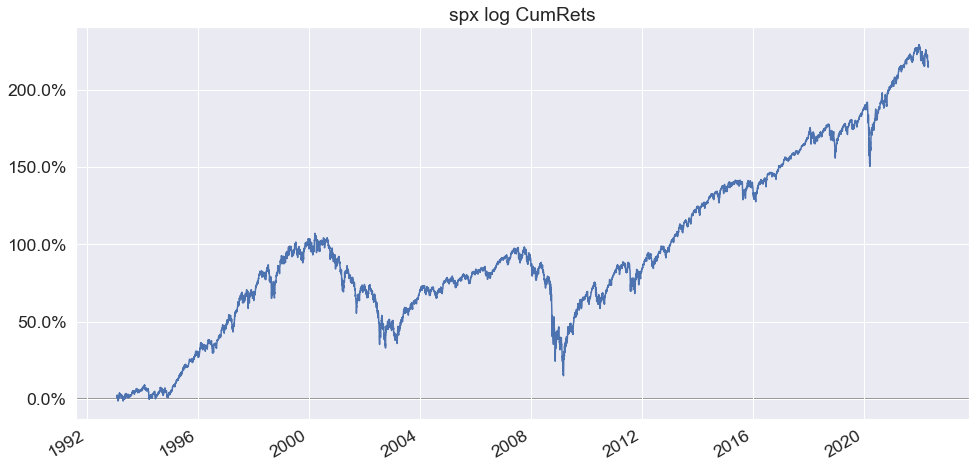

Sharpe    0.427482
ER        0.076460
Vol       0.178862
dtype: float64


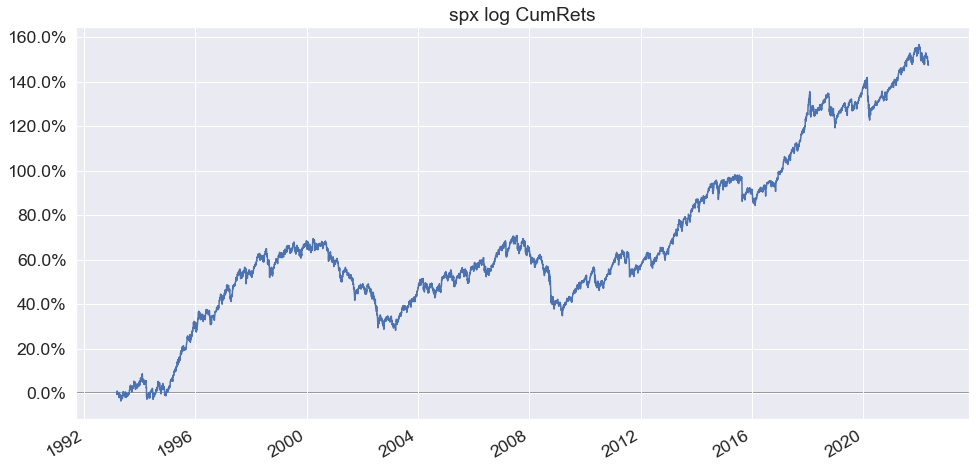

Sharpe    0.498917
ER        0.052550
Vol       0.105328
dtype: float64


In [5]:
_SPX_XR = get_spx_xr()
SPX_XR = fin.get_vol_targeted(xr=_SPX_XR)

fin.chart(r=_SPX_XR)
fin.chart(r=SPX_XR)

# performance of hedged vol-targeted mortgage-backed securities

In [6]:
fin.get_est_corr(y=MBS_XR, x=_MBS_XR)

0.8959859284673652

In [7]:
fin.get_est_corr(y=MBS_XR, x=TY_XR)

0.8045031483453079

In [8]:
fin.get_est_corr(y=MBS_XR, x=SPX_XR)

-0.23188561618306558

-0.5496440627161308 0.1470050658302898
-0.4397924377615446 -0.09367078669089951


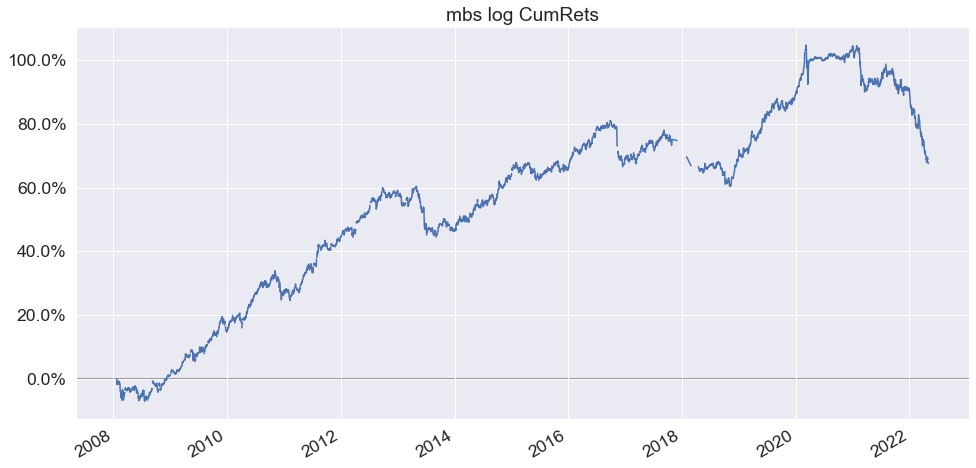

Sharpe    0.451352
ER        0.049323
Vol       0.109278
dtype: float64


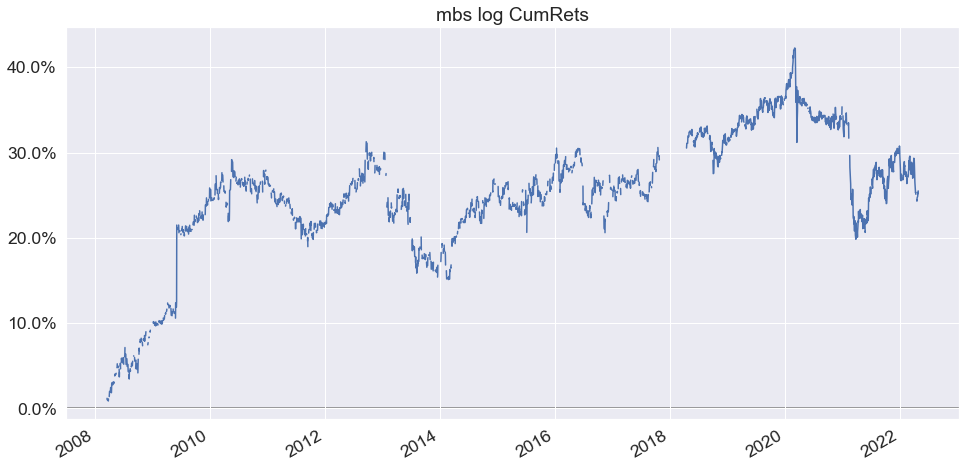

Sharpe    0.196820
ER        0.026836
Vol       0.136350
dtype: float64


In [9]:
MBSH_XR = fin.get_hedged(base_xr=MBS_XR, hedge_xr=TY_XR)
print(fin.get_est_corr(y=MBSH_XR, x=TY_XR), fin.get_est_corr(y=MBSH_XR, x=SPX_XR))

MBSH_XR = fin.get_hedged(base_xr=MBSH_XR, hedge_xr=SPX_XR)
print(fin.get_est_corr(y=MBSH_XR, x=TY_XR), fin.get_est_corr(y=MBSH_XR, x=SPX_XR))

fin.chart(r=MBS_XR)
fin.chart(r=MBSH_XR)